In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import os
import glob
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch

from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import random
from models_ukb import ModelAPIF, ModelBPIF
from hyperparameter_options import params_pif as hyperparams

In [6]:
torch.__version__

'1.0.0'

In [7]:
# use multiple GPUs
gpu = 2
multi_gpus = [2, 3]
zero_one_normalize = False
dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [10]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [11]:
# shuffle the dataset
df = df.sample(frac=1, random_state=23) # NOTE: use all!
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [12]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        path = path.replace("/analysis/ritter", "/ritter/share")
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        # normalize by max
        image /= np.max(image)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [13]:
augmentations = [SagittalFlip()]

# Define the classifier

In [14]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [15]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=None,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    all_outer_bests = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    random_states = np.arange(20, 22) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load new random data split each outer fold
        # separate new test set
        no_test_df = data.sample(frac=0.8, random_state=r) # split according 
         # split train/validation
        train_df = no_test_df.sample(frac=0.8, random_state=32) # can be the same r at each inner fold
        val_df = no_test_df[~no_test_df["PTID"].isin(train_df["PTID"])]
        
        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        print(len(ukb_data_train))
        print(len(ukb_data_val))
        
        print("Shuffled the data..")
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
        
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelAPIF"
            elif inner_fold < 4:
                model_name = "ModelBPIF"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])
            
            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)
            
            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            print("Trainable model parameters: {}".format(count_parameters(net)))
        
            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
        
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1

            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            train_loader = DataLoader(
                ukb_data_train, batch_size=b, shuffle=True, num_workers=4
            )

            val_loader = DataLoader(
                ukb_data_val, batch_size=2, shuffle=True, num_workers=2
            )

            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=60,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)
        all_outer_bests.append(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    print(all_outer_bests)
    return fold_metric, models

In [16]:
num_epochs = 200
min_iters = 3
ignore_epochs = 30
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [17]:
r = 0

In [18]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/full_set/10xrandom_splits/experiment_r2/"

###### Starting outer fold 0
1186
297
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    60] loss: 0.69500
[0,   120] loss: 0.70477
[0,   180] loss: 0.69329
Time elapsed: 0h:2m:0s
train accuracy_score: 52.28 %
train balanced_accuracy: 50.55 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.687826
[1,    60] loss: 0.67883
[1,   120] loss: 0.69311
[1,   180] loss: 0.69461
Time elapsed: 0h:5m:3s
train accuracy_score: 55.31 %
train balanced_accuracy: 52.96 %
val accuracy_score: 60.94 %
val balanced_accuracy: 59.07 %
Val loss: 0.691457
[2,    60] loss: 0.68688
[2,   120] loss: 0.68731
[2,   180] loss: 0.69660
Time elapsed: 0h:8m:2s
train accuracy_score: 52.02 %
train balanced_accuracy: 50.59 %
val accuracy_score: 62.29 %
val balanced_accuracy: 64.57 %
Val loss: 0.690919
[3,    60] loss: 0.69000
[3,   120] loss: 0.68902
[3,   180] loss: 0.68839
Time elapsed: 0

[33,    60] loss: 0.09953
[33,   120] loss: 0.18855
[33,   180] loss: 0.12020
Time elapsed: 1h:43m:14s
train accuracy_score: 94.69 %
train balanced_accuracy: 94.67 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.96 %
Val loss: 0.186813
[34,    60] loss: 0.08478
[34,   120] loss: 0.09407
[34,   180] loss: 0.13568
Time elapsed: 1h:46m:14s
train accuracy_score: 95.53 %
train balanced_accuracy: 95.48 %
val accuracy_score: 78.79 %
val balanced_accuracy: 80.56 %
Val loss: 0.785891
[35,    60] loss: 0.24162
[35,   120] loss: 0.15317
[35,   180] loss: 0.13488
Time elapsed: 1h:49m:24s
train accuracy_score: 92.58 %
train balanced_accuracy: 92.54 %
val accuracy_score: 87.88 %
val balanced_accuracy: 86.98 %
Val loss: 0.251172
[36,    60] loss: 0.16978
[36,   120] loss: 0.10607
[36,   180] loss: 0.09638
Time elapsed: 1h:52m:29s
train accuracy_score: 95.19 %
train balanced_accuracy: 95.08 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.73 %
Val loss: 0.182386
[37,    60] loss: 0.0854

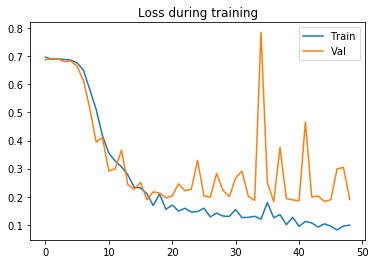

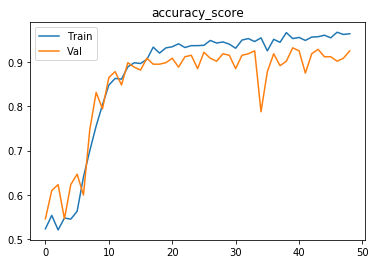

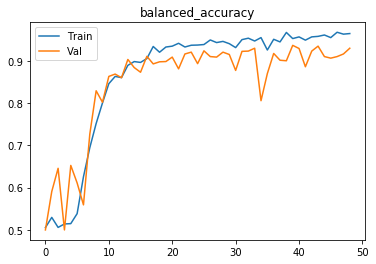

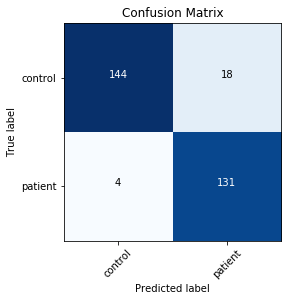

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    60] loss: 0.68983
Time elapsed: 0h:2m:44s
train accuracy_score: 53.29 %
train balanced_accuracy: 49.83 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.688229
[1,    60] loss: 0.69290
Time elapsed: 0h:6m:19s
train accuracy_score: 54.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.687444
[2,    60] loss: 0.69008
Time elapsed: 0h:9m:40s
train accuracy_score: 54.47 %
train balanced_accuracy: 50.18 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.685033
[3,    60] loss: 0.68965
Time elapsed: 0h:13m:9s
train accuracy_score: 54.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.682659
[4,    60] loss: 0.68657
Time elapsed: 0h:16m:35s
train accuracy_score: 55.40 %
train balanced_accuracy: 

Time elapsed: 2h:12m:11s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.78 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.40 %
Val loss: 0.234090
[43,    60] loss: 0.16103
Time elapsed: 2h:15m:7s
train accuracy_score: 93.00 %
train balanced_accuracy: 92.90 %
val accuracy_score: 88.22 %
val balanced_accuracy: 89.07 %
Val loss: 0.292784
[44,    60] loss: 0.17692
Time elapsed: 2h:18m:6s
train accuracy_score: 93.34 %
train balanced_accuracy: 93.36 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.05 %
Val loss: 0.194357
[45,    60] loss: 0.19102
Time elapsed: 2h:21m:4s
train accuracy_score: 92.41 %
train balanced_accuracy: 92.31 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.96 %
Val loss: 0.192273
[46,    60] loss: 0.15824
Time elapsed: 2h:24m:1s
train accuracy_score: 92.58 %
train balanced_accuracy: 92.54 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.16 %
Val loss: 0.178631
[47,    60] loss: 0.15703
Time elapsed: 2h:27m:1s
train accuracy_score

[85,    60] loss: 0.10574
Time elapsed: 4h:21m:7s
train accuracy_score: 95.45 %
train balanced_accuracy: 95.47 %
val accuracy_score: 94.95 %
val balanced_accuracy: 95.25 %
Val loss: 0.148392
[86,    60] loss: 0.13414
Time elapsed: 4h:24m:4s
train accuracy_score: 96.12 %
train balanced_accuracy: 96.15 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.51 %
Val loss: 0.137210
[87,    60] loss: 0.13856
Time elapsed: 4h:27m:4s
train accuracy_score: 94.18 %
train balanced_accuracy: 94.18 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.84 %
Val loss: 0.232667
[88,    60] loss: 0.10113
Time elapsed: 4h:30m:6s
train accuracy_score: 96.21 %
train balanced_accuracy: 96.17 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.77 %
Val loss: 0.167885
[89,    60] loss: 0.09742
Time elapsed: 4h:33m:5s
train accuracy_score: 95.78 %
train balanced_accuracy: 95.84 %
val accuracy_score: 93.94 %
val balanced_accuracy: 93.58 %
Val loss: 0.137574
[90,    60] loss: 0.10334
Time elapsed: 4h:36

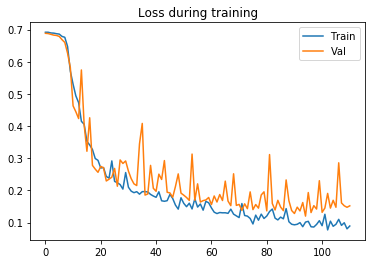

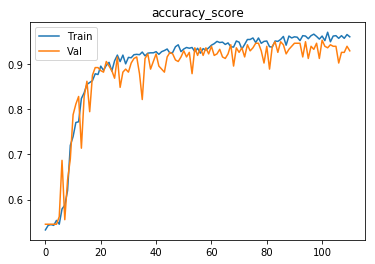

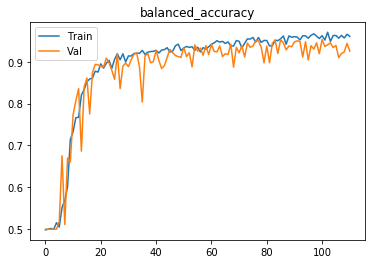

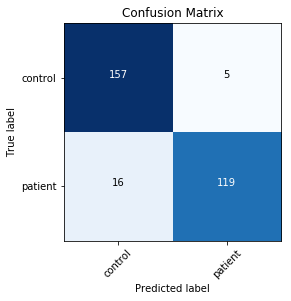

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    60] loss: 0.69305
Time elapsed: 0h:1m:59s
train accuracy_score: 54.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.688468
[1,    60] loss: 0.69312
Time elapsed: 0h:4m:56s
train accuracy_score: 54.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.687281
[2,    60] loss: 0.69052
Time elapsed: 0h:7m:54s
train accuracy_score: 54.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.687618
[3,    60] loss: 0.69061
Time elapsed: 0h:10m:53s
train accuracy_score: 54.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.685965
[4,    60] loss: 0.68910
Time elapsed: 0h:13m:52s
train accuracy_score: 53.96 %
train balanced_accuracy: 

Time elapsed: 2h:8m:3s
train accuracy_score: 89.80 %
train balanced_accuracy: 89.69 %
val accuracy_score: 85.86 %
val balanced_accuracy: 86.17 %
Val loss: 0.300136
[43,    60] loss: 0.25587
Time elapsed: 2h:11m:2s
train accuracy_score: 90.98 %
train balanced_accuracy: 90.99 %
val accuracy_score: 89.90 %
val balanced_accuracy: 89.94 %
Val loss: 0.269220
[44,    60] loss: 0.24000
Time elapsed: 2h:14m:3s
train accuracy_score: 88.45 %
train balanced_accuracy: 88.36 %
val accuracy_score: 87.54 %
val balanced_accuracy: 87.28 %
Val loss: 0.291463
[45,    60] loss: 0.23623
Time elapsed: 2h:17m:2s
train accuracy_score: 90.05 %
train balanced_accuracy: 89.99 %
val accuracy_score: 88.89 %
val balanced_accuracy: 88.83 %
Val loss: 0.275729
[46,    60] loss: 0.24309
Time elapsed: 2h:19m:57s
train accuracy_score: 89.29 %
train balanced_accuracy: 89.22 %
val accuracy_score: 83.16 %
val balanced_accuracy: 84.20 %
Val loss: 0.425638
[47,    60] loss: 0.22815
Time elapsed: 2h:22m:55s
train accuracy_score

[85,    60] loss: 0.16892
Time elapsed: 4h:17m:4s
train accuracy_score: 93.34 %
train balanced_accuracy: 93.33 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.73 %
Val loss: 0.201575
[86,    60] loss: 0.15712
Time elapsed: 4h:20m:6s
train accuracy_score: 93.09 %
train balanced_accuracy: 93.08 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.17 %
Val loss: 0.212813
[87,    60] loss: 0.14774
Time elapsed: 4h:23m:6s
train accuracy_score: 93.42 %
train balanced_accuracy: 93.33 %
val accuracy_score: 90.91 %
val balanced_accuracy: 90.86 %
Val loss: 0.211750
[88,    60] loss: 0.16089
Time elapsed: 4h:26m:9s
train accuracy_score: 93.17 %
train balanced_accuracy: 93.13 %
val accuracy_score: 88.55 %
val balanced_accuracy: 89.14 %
Val loss: 0.253507
[89,    60] loss: 0.15066
Time elapsed: 4h:29m:10s
train accuracy_score: 92.33 %
train balanced_accuracy: 92.23 %
val accuracy_score: 90.91 %
val balanced_accuracy: 90.80 %
Val loss: 0.210725
[90,    60] loss: 0.13994
Time elapsed: 4h:3

val accuracy_score: 91.25 %
val balanced_accuracy: 90.93 %
Val loss: 0.185175
[128,    60] loss: 0.12981
Time elapsed: 6h:26m:39s
train accuracy_score: 95.36 %
train balanced_accuracy: 95.31 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.05 %
Val loss: 0.192509
[129,    60] loss: 0.15787
Time elapsed: 6h:29m:36s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.72 %
val accuracy_score: 92.93 %
val balanced_accuracy: 92.96 %
Val loss: 0.166391
[130,    60] loss: 0.13165
Time elapsed: 6h:32m:36s
train accuracy_score: 94.52 %
train balanced_accuracy: 94.50 %
val accuracy_score: 91.25 %
val balanced_accuracy: 90.56 %
Val loss: 0.236230
[131,    60] loss: 0.12472
Time elapsed: 6h:35m:37s
train accuracy_score: 94.69 %
train balanced_accuracy: 94.70 %
val accuracy_score: 92.93 %
val balanced_accuracy: 92.78 %
Val loss: 0.173902
[132,    60] loss: 0.09924
Time elapsed: 6h:38m:36s
train accuracy_score: 95.53 %
train balanced_accuracy: 95.56 %
val accuracy_score: 89.90 %
val bal

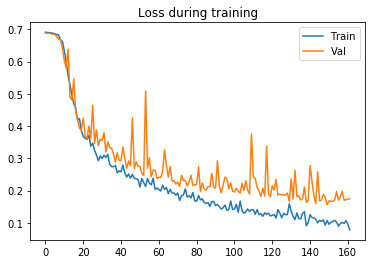

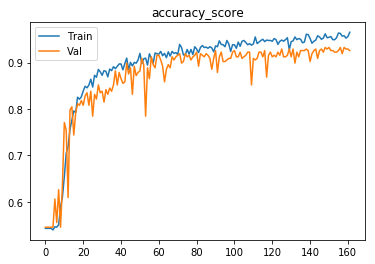

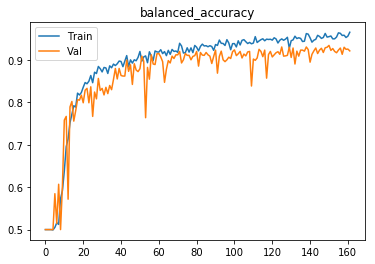

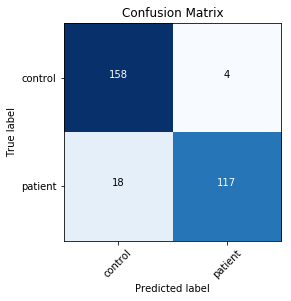

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    60] loss: 0.69408
[0,   120] loss: 0.69241
[0,   180] loss: 0.69254
Time elapsed: 0h:1m:58s
train accuracy_score: 51.94 %
train balanced_accuracy: 49.27 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.688032
[1,    60] loss: 0.69030
[1,   120] loss: 0.69280
[1,   180] loss: 0.69084
Time elapsed: 0h:4m:55s
train accuracy_score: 53.79 %
train balanced_accuracy: 50.44 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.685324
[2,    60] loss: 0.68950
[2,   120] loss: 0.69267
[2,   180] loss: 0.68978
Time elapsed: 0h:7m:55s
train accuracy_score: 54.05 %
train balanced_accuracy: 49.91 %
val accuracy_score: 70.37 %
val balanced_accuracy: 71.17 %
Val loss: 0.690006
[3,    60] loss: 0.69001
[3,   120] loss: 0.67950
[3,   180] loss: 0.68804
Time elapsed: 0h:10m:55s
train accuracy_score: 54.55 %
train balanced_a

[33,   180] loss: 0.14952
Time elapsed: 1h:40m:14s
train accuracy_score: 92.24 %
train balanced_accuracy: 92.16 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.42 %
Val loss: 0.211216
[34,    60] loss: 0.16337
[34,   120] loss: 0.18971
[34,   180] loss: 0.17544
Time elapsed: 1h:43m:14s
train accuracy_score: 92.50 %
train balanced_accuracy: 92.45 %
val accuracy_score: 90.24 %
val balanced_accuracy: 90.62 %
Val loss: 0.234092
[35,    60] loss: 0.15924
[35,   120] loss: 0.16172
[35,   180] loss: 0.18757
Time elapsed: 1h:46m:13s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.77 %
val accuracy_score: 90.24 %
val balanced_accuracy: 89.75 %
Val loss: 0.232535
[36,    60] loss: 0.15423
[36,   120] loss: 0.14595
[36,   180] loss: 0.16841
Time elapsed: 1h:49m:10s
train accuracy_score: 93.93 %
train balanced_accuracy: 93.94 %
val accuracy_score: 90.91 %
val balanced_accuracy: 91.11 %
Val loss: 0.226582
[37,    60] loss: 0.16243
[37,   120] loss: 0.17240
[37,   180] loss: 0.1398

[67,    60] loss: 0.07214
[67,   120] loss: 0.07535
[67,   180] loss: 0.09118
Time elapsed: 3h:21m:32s
train accuracy_score: 96.29 %
train balanced_accuracy: 96.28 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.16 %
Val loss: 0.181081
[68,    60] loss: 0.09147
[68,   120] loss: 0.06604
[68,   180] loss: 0.08760
Time elapsed: 3h:24m:30s
train accuracy_score: 95.70 %
train balanced_accuracy: 95.65 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.91 %
Val loss: 0.248216
[69,    60] loss: 0.06098
[69,   120] loss: 0.07860
[69,   180] loss: 0.08032
Time elapsed: 3h:27m:26s
train accuracy_score: 96.96 %
train balanced_accuracy: 96.96 %
val accuracy_score: 90.24 %
val balanced_accuracy: 89.51 %
Val loss: 0.246072
[70,    60] loss: 0.07665
[70,   120] loss: 0.08598
[70,   180] loss: 0.06519
Time elapsed: 3h:30m:24s
train accuracy_score: 96.21 %
train balanced_accuracy: 96.14 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.38 %
Val loss: 0.142667
[71,    60] loss: 0.0725

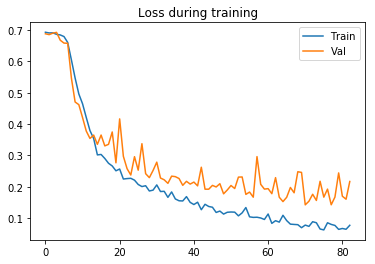

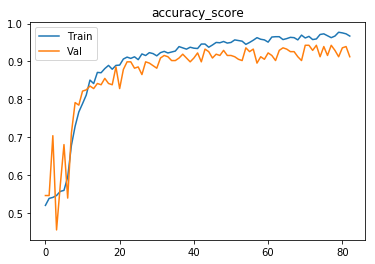

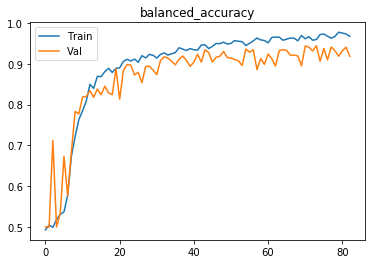

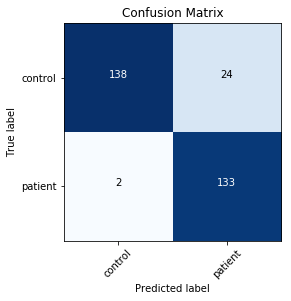

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    60] loss: 0.69606
[0,   120] loss: 0.69169
[0,   180] loss: 0.69027
Time elapsed: 0h:1m:55s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.78 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.687442
[1,    60] loss: 0.69686
[1,   120] loss: 0.68851
[1,   180] loss: 0.68523
Time elapsed: 0h:4m:48s
train accuracy_score: 53.63 %
train balanced_accuracy: 49.77 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.686734
[2,    60] loss: 0.69116
[2,   120] loss: 0.68918
[2,   180] loss: 0.68748
Time elapsed: 0h:7m:42s
train accuracy_score: 53.63 %
train balanced_accuracy: 49.47 %
val accuracy_score: 54.55 %
val balanced_accuracy: 50.00 %
Val loss: 0.684767
[3,    60] loss: 0.69407
[3,   120] loss: 0.68941
[3,   180] loss: 0.68544
Time elapsed: 0h:10m:36s
train accuracy_score: 54.64 %
train balanced_a

[33,   180] loss: 0.19957
Time elapsed: 1h:38m:9s
train accuracy_score: 91.99 %
train balanced_accuracy: 91.95 %
val accuracy_score: 90.24 %
val balanced_accuracy: 89.51 %
Val loss: 0.239499
[34,    60] loss: 0.14269
[34,   120] loss: 0.19086
[34,   180] loss: 0.18461
Time elapsed: 1h:41m:5s
train accuracy_score: 92.33 %
train balanced_accuracy: 92.22 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.85 %
Val loss: 0.195033
[35,    60] loss: 0.16848
[35,   120] loss: 0.13907
[35,   180] loss: 0.17786
Time elapsed: 1h:44m:0s
train accuracy_score: 93.59 %
train balanced_accuracy: 93.60 %
val accuracy_score: 90.24 %
val balanced_accuracy: 89.51 %
Val loss: 0.254981
[36,    60] loss: 0.15149
[36,   120] loss: 0.17744
[36,   180] loss: 0.15749
Time elapsed: 1h:46m:56s
train accuracy_score: 92.83 %
train balanced_accuracy: 92.79 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.05 %
Val loss: 0.209704
[37,    60] loss: 0.11680
[37,   120] loss: 0.13214
[37,   180] loss: 0.17547
T

[67,    60] loss: 0.11556
[67,   120] loss: 0.12582
[67,   180] loss: 0.09465
Time elapsed: 3h:17m:37s
train accuracy_score: 95.70 %
train balanced_accuracy: 95.70 %
val accuracy_score: 92.93 %
val balanced_accuracy: 92.65 %
Val loss: 0.150777
[68,    60] loss: 0.07469
[68,   120] loss: 0.10195
[68,   180] loss: 0.08626
Time elapsed: 3h:20m:35s
train accuracy_score: 96.71 %
train balanced_accuracy: 96.68 %
val accuracy_score: 90.24 %
val balanced_accuracy: 89.32 %
Val loss: 0.268051
[69,    60] loss: 0.05681
[69,   120] loss: 0.07379
[69,   180] loss: 0.08634
Time elapsed: 3h:23m:33s
train accuracy_score: 96.71 %
train balanced_accuracy: 96.75 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.28 %
Val loss: 0.150121
[70,    60] loss: 0.08331
[70,   120] loss: 0.07606
[70,   180] loss: 0.07624
Time elapsed: 3h:26m:32s
train accuracy_score: 96.63 %
train balanced_accuracy: 96.60 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.57 %
Val loss: 0.162645
[71,    60] loss: 0.0806

val accuracy_score: 93.94 %
val balanced_accuracy: 93.58 %
Val loss: 0.154821
[101,    60] loss: 0.04806
[101,   120] loss: 0.05345
[101,   180] loss: 0.05645
Time elapsed: 4h:57m:46s
train accuracy_score: 97.22 %
train balanced_accuracy: 97.20 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.57 %
Val loss: 0.173345
[102,    60] loss: 0.07297
[102,   120] loss: 0.06382
[102,   180] loss: 0.03192
Time elapsed: 5h:0m:42s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.33 %
val accuracy_score: 94.95 %
val balanced_accuracy: 95.25 %
Val loss: 0.169146
[103,    60] loss: 0.04353
[103,   120] loss: 0.05492
[103,   180] loss: 0.09246
Time elapsed: 5h:3m:37s
train accuracy_score: 97.13 %
train balanced_accuracy: 97.14 %
val accuracy_score: 94.95 %
val balanced_accuracy: 95.00 %
Val loss: 0.142350
Early stopping in epoch 104
Total time elapsed: 5h:4m:38s
Writing model to disk...
Best result during training: 0.95. Saving model..
Finished inner fold.


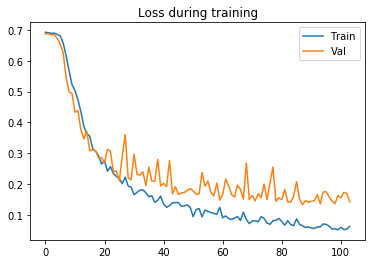

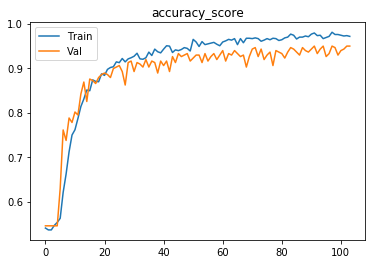

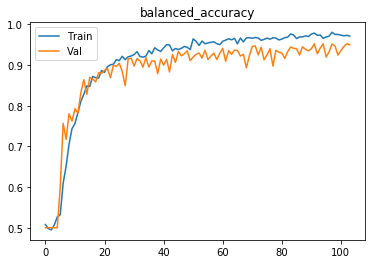

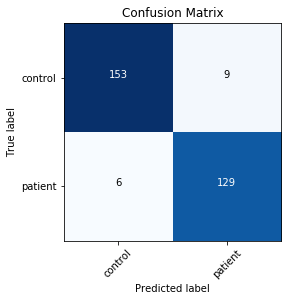

Finished outer fold.
{'final_acc': 0.95, 'best_acc': 0.9524691358024691, 'final_iter': 104, 'best_iter': 103, 'params': {'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}
###### Starting outer fold 1
1186
297
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    60] loss: 0.69440
Time elapsed: 0h:1m:58s
train accuracy_score: 52.19 %
train balanced_accuracy: 50.61 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.688645
[1,    60] loss: 0.69074
Time elapsed: 0h:4m:56s
train accuracy_score: 51.69 %
train balanced_accuracy: 50.10 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.691544
[2,    60] loss: 0.69041
Time elapsed: 0h:7m:53s
train accuracy_score: 54.13 %
train balanced_accuracy: 52.29 %
val accuracy_score: 44.44 %
val balanced_accuracy: 50.00 %
Val loss: 0.709961
[3,    60] loss: 0.69323


[41,    60] loss: 0.14574
Time elapsed: 2h:3m:39s
train accuracy_score: 94.27 %
train balanced_accuracy: 94.29 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.73 %
Val loss: 0.197740
[42,    60] loss: 0.13619
Time elapsed: 2h:6m:39s
train accuracy_score: 93.42 %
train balanced_accuracy: 93.42 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.58 %
Val loss: 0.202112
[43,    60] loss: 0.14047
Time elapsed: 2h:9m:37s
train accuracy_score: 94.77 %
train balanced_accuracy: 94.80 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.88 %
Val loss: 0.174789
[44,    60] loss: 0.12470
Time elapsed: 2h:12m:34s
train accuracy_score: 95.45 %
train balanced_accuracy: 95.47 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.33 %
Val loss: 0.176901
[45,    60] loss: 0.16862
Time elapsed: 2h:15m:30s
train accuracy_score: 93.93 %
train balanced_accuracy: 93.93 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.95 %
Val loss: 0.196400
[46,    60] loss: 0.13210
Time elapsed: 2h:

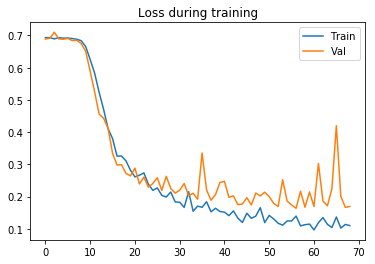

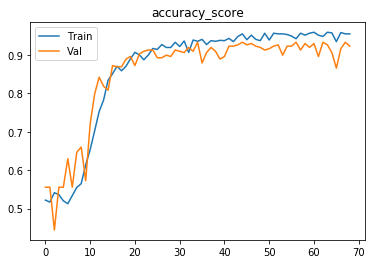

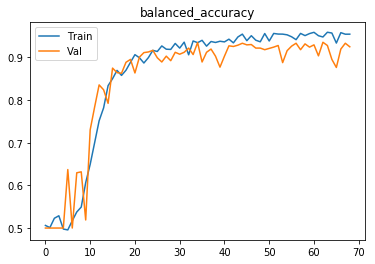

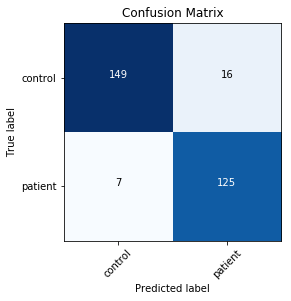

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    60] loss: 0.69370
[0,   120] loss: 0.68418
[0,   180] loss: 0.69479
[0,   240] loss: 0.69268
Time elapsed: 0h:1m:54s
train accuracy_score: 53.46 %
train balanced_accuracy: 52.78 %
val accuracy_score: 44.44 %
val balanced_accuracy: 50.00 %
Val loss: 0.695793
[1,    60] loss: 0.69282
[1,   120] loss: 0.69525
[1,   180] loss: 0.69535
[1,   240] loss: 0.69349
Time elapsed: 0h:4m:50s
train accuracy_score: 51.77 %
train balanced_accuracy: 50.88 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.684943
[2,    60] loss: 0.69899
[2,   120] loss: 0.68893
[2,   180] loss: 0.68551
[2,   240] loss: 0.69406
Time elapsed: 0h:7m:46s
train accuracy_score: 53.63 %
train balanced_accuracy: 51.75 %
val accuracy_score: 63.64 %
val balanced_accuracy: 61.44 %
Val loss: 0.687617
[3,    60] loss: 0.68826
[3,   120] loss: 0.68305
[3,   180] loss: 0.68

[30,   120] loss: 0.16215
[30,   180] loss: 0.18732
[30,   240] loss: 0.14510
Time elapsed: 1h:29m:39s
train accuracy_score: 93.51 %
train balanced_accuracy: 93.52 %
val accuracy_score: 91.25 %
val balanced_accuracy: 90.53 %
Val loss: 0.175271
[31,    60] loss: 0.17138
[31,   120] loss: 0.17340
[31,   180] loss: 0.17843
[31,   240] loss: 0.15020
Time elapsed: 1h:32m:36s
train accuracy_score: 93.42 %
train balanced_accuracy: 93.42 %
val accuracy_score: 91.58 %
val balanced_accuracy: 90.68 %
Val loss: 0.185028
[32,    60] loss: 0.16364
[32,   120] loss: 0.12685
[32,   180] loss: 0.14485
[32,   240] loss: 0.17103
Time elapsed: 1h:35m:31s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.78 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.73 %
Val loss: 0.218779
[33,    60] loss: 0.16465
[33,   120] loss: 0.14824
[33,   180] loss: 0.17783
[33,   240] loss: 0.15910
Time elapsed: 1h:38m:24s
train accuracy_score: 93.25 %
train balanced_accuracy: 93.21 %
val accuracy_score: 91.5

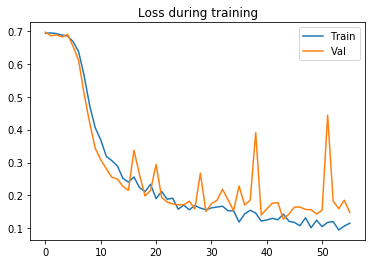

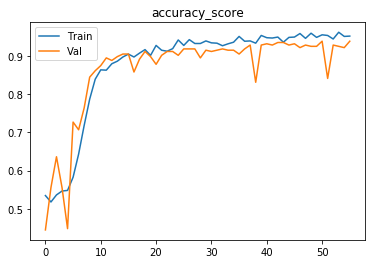

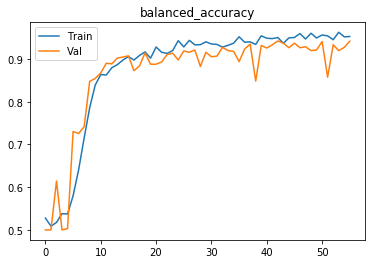

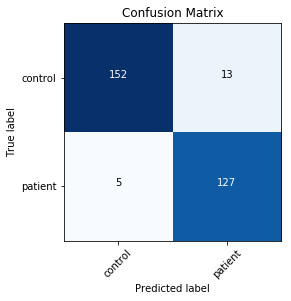

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    60] loss: 0.69547
[0,   120] loss: 0.69617
[0,   180] loss: 0.69823
[0,   240] loss: 0.69368
Time elapsed: 0h:1m:53s
train accuracy_score: 51.01 %
train balanced_accuracy: 49.09 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.686699
[1,    60] loss: 0.69339
[1,   120] loss: 0.69500
[1,   180] loss: 0.69048
[1,   240] loss: 0.68788
Time elapsed: 0h:4m:46s
train accuracy_score: 51.60 %
train balanced_accuracy: 49.52 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.689389
[2,    60] loss: 0.69571
[2,   120] loss: 0.68764
[2,   180] loss: 0.69038
[2,   240] loss: 0.69244
Time elapsed: 0h:7m:34s
train accuracy_score: 52.19 %
train balanced_accuracy: 50.29 %
val accuracy_score: 59.26 %
val balanced_accuracy: 62.73 %
Val loss: 0.691361
[3,    60] loss: 0.69233
[3,   120] loss: 0.68744
[3,   180] loss: 0.69

[30,   120] loss: 0.19095
[30,   180] loss: 0.11857
[30,   240] loss: 0.14643
Time elapsed: 1h:29m:20s
train accuracy_score: 94.27 %
train balanced_accuracy: 94.24 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.74 %
Val loss: 0.206887
[31,    60] loss: 0.13023
[31,   120] loss: 0.20719
[31,   180] loss: 0.14067
[31,   240] loss: 0.11571
Time elapsed: 1h:32m:14s
train accuracy_score: 94.10 %
train balanced_accuracy: 94.09 %
val accuracy_score: 90.57 %
val balanced_accuracy: 90.08 %
Val loss: 0.179492
[32,    60] loss: 0.13042
[32,   120] loss: 0.08975
[32,   180] loss: 0.16647
[32,   240] loss: 0.12778
Time elapsed: 1h:35m:8s
train accuracy_score: 95.19 %
train balanced_accuracy: 95.22 %
val accuracy_score: 91.25 %
val balanced_accuracy: 90.98 %
Val loss: 0.180913
[33,    60] loss: 0.15299
[33,   120] loss: 0.17269
[33,   180] loss: 0.17896
[33,   240] loss: 0.18628
Time elapsed: 1h:38m:2s
train accuracy_score: 93.93 %
train balanced_accuracy: 93.93 %
val accuracy_score: 91.58 

val accuracy_score: 92.59 %
val balanced_accuracy: 91.82 %
Val loss: 0.250595
[61,    60] loss: 0.07023
[61,   120] loss: 0.07263
[61,   180] loss: 0.08270
[61,   240] loss: 0.08631
Time elapsed: 3h:0m:43s
train accuracy_score: 96.80 %
train balanced_accuracy: 96.80 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.64 %
Val loss: 0.174053
[62,    60] loss: 0.04006
[62,   120] loss: 0.08670
[62,   180] loss: 0.07783
[62,   240] loss: 0.10016
Time elapsed: 3h:3m:40s
train accuracy_score: 96.88 %
train balanced_accuracy: 96.91 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.56 %
Val loss: 0.139532
[63,    60] loss: 0.09725
[63,   120] loss: 0.07202
[63,   180] loss: 0.10912
[63,   240] loss: 0.07964
Time elapsed: 3h:6m:43s
train accuracy_score: 96.80 %
train balanced_accuracy: 96.78 %
val accuracy_score: 92.93 %
val balanced_accuracy: 92.58 %
Val loss: 0.154100
[64,    60] loss: 0.06895
[64,   120] loss: 0.04279
[64,   180] loss: 0.08117
[64,   240] loss: 0.09180
Time elapse

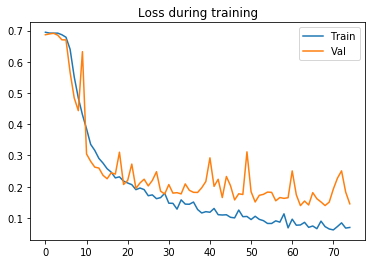

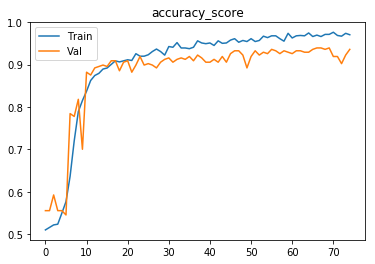

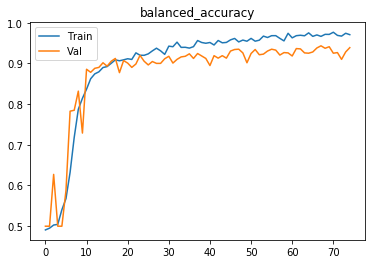

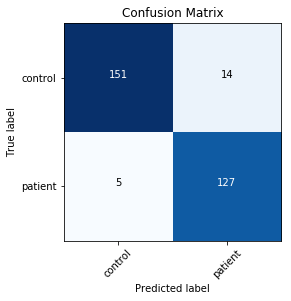

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    60] loss: 0.69388
[0,   120] loss: 0.69548
[0,   180] loss: 0.68371
[0,   240] loss: 0.70303
Time elapsed: 0h:1m:59s
train accuracy_score: 52.19 %
train balanced_accuracy: 51.58 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.687243
[1,    60] loss: 0.70358
[1,   120] loss: 0.68487
[1,   180] loss: 0.68864
[1,   240] loss: 0.69511
Time elapsed: 0h:5m:0s
train accuracy_score: 53.04 %
train balanced_accuracy: 51.64 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.688965
[2,    60] loss: 0.69382
[2,   120] loss: 0.69480
[2,   180] loss: 0.69351
[2,   240] loss: 0.69117
Time elapsed: 0h:8m:2s
train accuracy_score: 51.18 %
train balanced_accuracy: 49.03 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.687269
[3,    60] loss: 0.69043
[3,   120] loss: 0.69452
[3,   180] loss: 0.6923

[30,   120] loss: 0.23354
[30,   180] loss: 0.14424
[30,   240] loss: 0.22826
Time elapsed: 1h:32m:20s
train accuracy_score: 92.07 %
train balanced_accuracy: 92.10 %
val accuracy_score: 92.26 %
val balanced_accuracy: 91.67 %
Val loss: 0.174249
[31,    60] loss: 0.16074
[31,   120] loss: 0.15984
[31,   180] loss: 0.16009
[31,   240] loss: 0.24719
Time elapsed: 1h:35m:22s
train accuracy_score: 92.92 %
train balanced_accuracy: 92.93 %
val accuracy_score: 90.57 %
val balanced_accuracy: 91.29 %
Val loss: 0.241135
[32,    60] loss: 0.15422
[32,   120] loss: 0.21451
[32,   180] loss: 0.21301
[32,   240] loss: 0.19180
Time elapsed: 1h:38m:20s
train accuracy_score: 92.33 %
train balanced_accuracy: 92.32 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.27 %
Val loss: 0.189913
[33,    60] loss: 0.14324
[33,   120] loss: 0.20444
[33,   180] loss: 0.20354
[33,   240] loss: 0.15731
Time elapsed: 1h:41m:17s
train accuracy_score: 93.68 %
train balanced_accuracy: 93.67 %
val accuracy_score: 92.2

val accuracy_score: 91.58 %
val balanced_accuracy: 92.20 %
Val loss: 0.198748
[61,    60] loss: 0.11049
[61,   120] loss: 0.09836
[61,   180] loss: 0.08426
[61,   240] loss: 0.12030
Time elapsed: 3h:5m:48s
train accuracy_score: 96.04 %
train balanced_accuracy: 96.03 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.50 %
Val loss: 0.200110
[62,    60] loss: 0.10670
[62,   120] loss: 0.06950
[62,   180] loss: 0.10810
[62,   240] loss: 0.12909
Time elapsed: 3h:8m:45s
train accuracy_score: 95.78 %
train balanced_accuracy: 95.80 %
val accuracy_score: 90.57 %
val balanced_accuracy: 91.36 %
Val loss: 0.270376
[63,    60] loss: 0.07259
[63,   120] loss: 0.07997
[63,   180] loss: 0.03777
[63,   240] loss: 0.10211
Time elapsed: 3h:11m:45s
train accuracy_score: 96.46 %
train balanced_accuracy: 96.48 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.71 %
Val loss: 0.167687
[64,    60] loss: 0.08298
[64,   120] loss: 0.10254
[64,   180] loss: 0.08338
[64,   240] loss: 0.07762
Time elaps

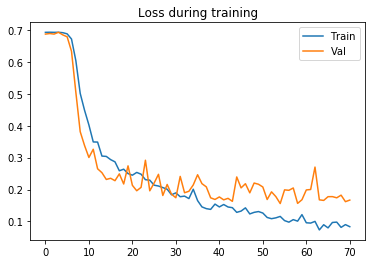

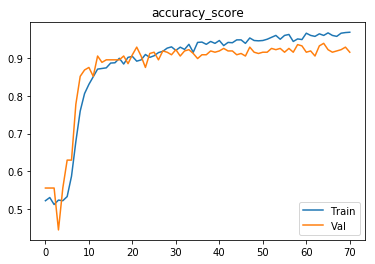

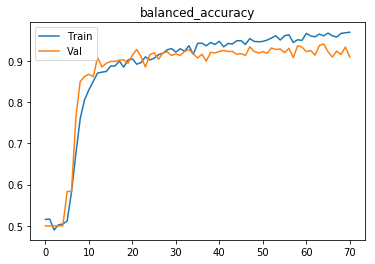

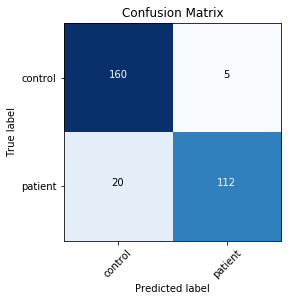

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    60] loss: 0.69473
Time elapsed: 0h:1m:58s
train accuracy_score: 49.75 %
train balanced_accuracy: 48.13 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.690475
[1,    60] loss: 0.69283
Time elapsed: 0h:4m:58s
train accuracy_score: 54.30 %
train balanced_accuracy: 52.62 %
val accuracy_score: 50.17 %
val balanced_accuracy: 54.70 %
Val loss: 0.692770
[2,    60] loss: 0.69162
Time elapsed: 0h:7m:57s
train accuracy_score: 52.45 %
train balanced_accuracy: 51.43 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.685344
[3,    60] loss: 0.69254
Time elapsed: 0h:10m:56s
train accuracy_score: 52.78 %
train balanced_accuracy: 51.49 %
val accuracy_score: 55.56 %
val balanced_accuracy: 50.00 %
Val loss: 0.680486
[4,    60] loss: 0.68988
Time elapsed: 0h:13m:54s
train accuracy_score: 54.22 %
train balanced_accuracy:

Time elapsed: 2h:7m:2s
train accuracy_score: 92.92 %
train balanced_accuracy: 92.93 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.67 %
Val loss: 0.193197
[43,    60] loss: 0.16539
Time elapsed: 2h:10m:2s
train accuracy_score: 93.17 %
train balanced_accuracy: 93.19 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.36 %
Val loss: 0.195173
[44,    60] loss: 0.16866
Time elapsed: 2h:13m:2s
train accuracy_score: 93.51 %
train balanced_accuracy: 93.50 %
val accuracy_score: 91.92 %
val balanced_accuracy: 92.58 %
Val loss: 0.267025
[45,    60] loss: 0.16920
Time elapsed: 2h:16m:2s
train accuracy_score: 92.83 %
train balanced_accuracy: 92.89 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.27 %
Val loss: 0.192018
[46,    60] loss: 0.15414
Time elapsed: 2h:19m:2s
train accuracy_score: 92.75 %
train balanced_accuracy: 92.79 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.67 %
Val loss: 0.202498
[47,    60] loss: 0.14452
Time elapsed: 2h:22m:0s
train accuracy_score: 

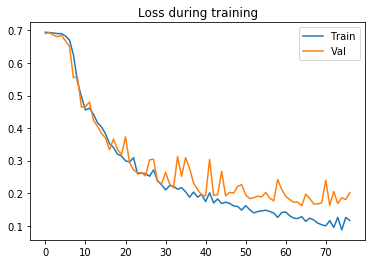

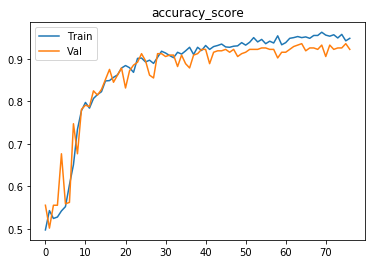

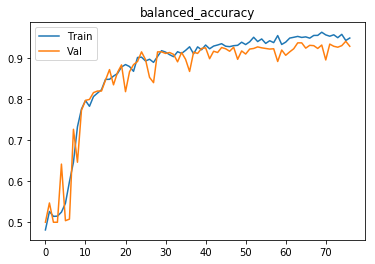

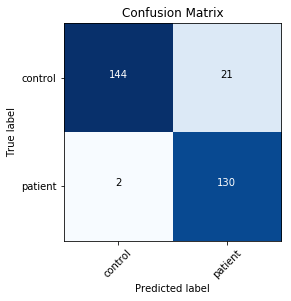

Finished outer fold.
{'final_acc': 0.9386363636363637, 'best_acc': 0.9431818181818182, 'final_iter': 75, 'best_iter': 68, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 2}
################################
################################
All accuracies: [0.9296296296296295, 0.9253086419753086, 0.9209876543209875, 0.9185185185185185, 0.95, 0.925, 0.9416666666666667, 0.9386363636363637, 0.9090909090909091, 0.9287878787878787]
Best accuracies mean: 0.9262079124579126 All :[0.9180246913580247, 0.9317283950617282, 0.922716049382716, 0.9281481481481482, 0.9412345679012345, 0.9171212121212122, 0.9216666666666666, 0.9315151515151516, 0.9228787878787879, 0.9270454545454545]
[{'final_acc': 0.95, 'best_acc': 0.9524691358024691, 'final_iter': 104, 'best_iter': 103, 'params': {'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}, {'final_acc': 0.9386363636363637, 'best_acc': 0.9431818181818182, 'final_iter': 7

In [19]:
fold_metric, models = run(net=None, data=df,
                  k_folds=-1,
                  callbacks=None,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [20]:
5/0

ZeroDivisionError: division by zero

In [23]:
training_res = [{'final_acc': 0.95, 'best_acc': 0.9524691358024691, 'final_iter': 104, 'best_iter': 103, 'params': {'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}, {'final_acc': 0.9386363636363637, 'best_acc': 0.9431818181818182, 'final_iter': 75, 'best_iter': 68, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 2}]

# Start inference

In [25]:
from collections import OrderedDict

In [26]:
metrics = []

random_states = np.arange(20, 22) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    state_dict = torch.load(model_dir, map_location='cpu')
    new_state_dict = OrderedDict()
    for param in state_dict.items():
        new_state_dict.update([(param[0].replace("module.", ""), param[1])])
    
    net.load_state_dict(new_state_dict)
    net = net.cuda(gpu)
    net.eval()
    
    # load data
    # separate new test set each run
    no_test_df = df.sample(frac=0.8, random_state=r) # split according 
    test_df = df[~df["PTID"].isin(no_test_df["PTID"])]

    if zero_one_normalize:
        intensity = IntensityRescale()
        ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
    else:
        ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
    test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
    )
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Bal Acc"])*100, np.std(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["ROC AUC"])*100, np.std(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Sensitivity"])*100, np.std(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Specificity"])*100, np.std(metrics_df["Specificity"])*100))

Outer fold 0
Bal. accuracy 94.645 %
ROC AUC Score 99.293 %
Sensitivity 98.837 %
Specificity 90.452 %
Outer fold 1
Bal. accuracy 93.779 %
ROC AUC Score 98.912 %
Sensitivity 96.732 %
Specificity 90.826 %
######## Final results ########
    Bal Acc   ROC AUC  Sensitivity  Specificity
0  0.946447  0.992930     0.988372     0.904523
1  0.937789  0.989117     0.967320     0.908257
Balanced accuracy mean 94.212 % (0.43)
ROC AUC mean 99.102 % (0.19)
Sensitivity mean 97.785 % (1.05)
Specificity mean 90.639 % (0.19)
